<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder

## 1.1. Подготовка данных

In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize

import gdown
%matplotlib inline

In [2]:
# Download some attributes

!gdown --id 1utdTz3TY2LyqoRHzZJVVeiku44pacQ0Y

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1utdTz3TY2LyqoRHzZJVVeiku44pacQ0Y
To: /content/lfw_attributes.txt
100% 14.9M/14.9M [00:00<00:00, 65.3MB/s]


In [3]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [4]:
# The following line fetches two datasets: images, usable for autoencoder training and attributes.

data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done


Разобьём выборку картинок на train и val, а также выведем несколько картинок в output, чтобы посмотреть, как они выглядят. Затем приведём картинки к тензорам pytorch, чтобы можно было скормить их сети:

Посмотрим сначала на размерности наших данных и аттрибутов

In [5]:
print("Data shape:", data.shape)
print("Attributes shape:", attrs.shape)
print("\nAttribute columns:", attrs.columns.tolist())

Data shape: (13143, 64, 64, 3)
Attributes shape: (13143, 73)

Attribute columns: ['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth', 'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair', 'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling', 'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash', 'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair', 'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead', 'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows', 'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose', 'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open', 'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee', 'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face', 'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man', 'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes', 'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pale Skin', "5 o' 

Делим выборку на тренировку и валидацию

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data, attrs, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

Training set shape: (10514, 64, 64, 3)
Validation set shape: (2629, 64, 64, 3)


Смотрим на отдельные лица

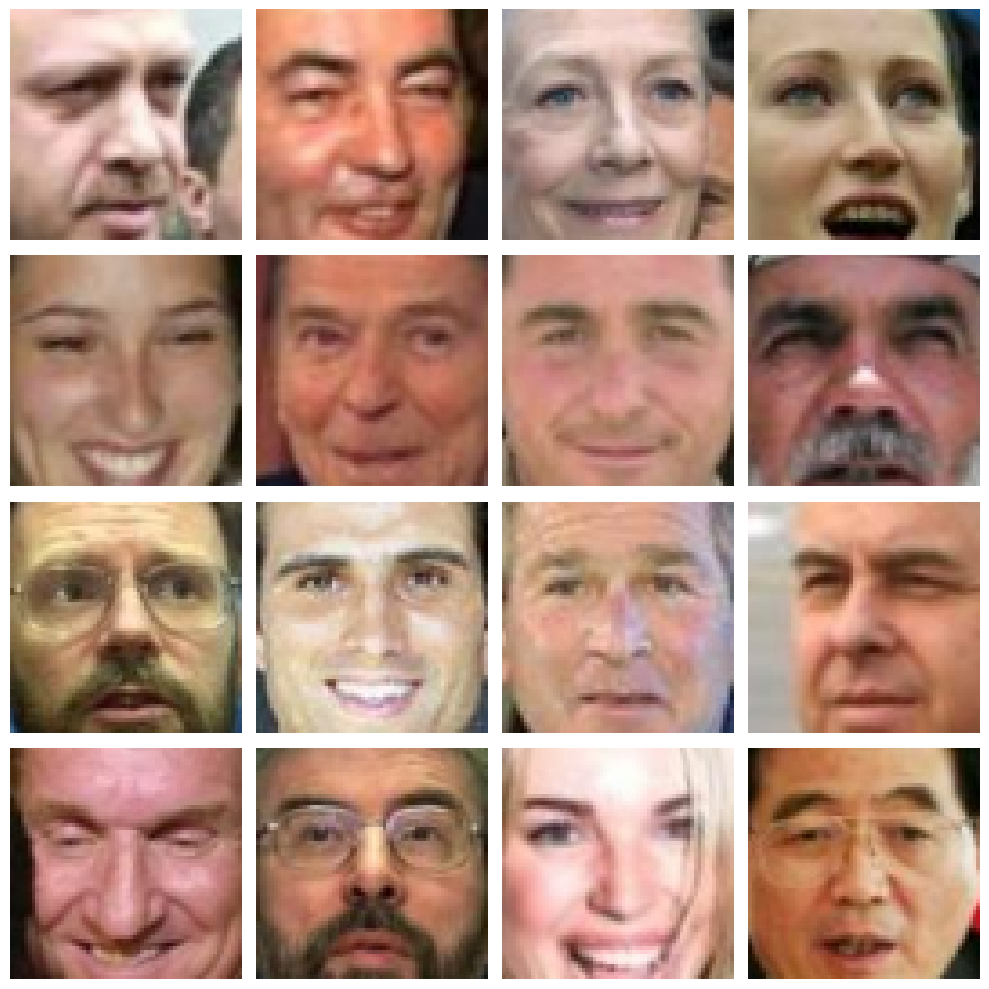

In [7]:
import matplotlib.pyplot as plt

def plot_images(images, n_rows=4, n_cols=4, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    for i in range(min(n_rows * n_cols, len(images))):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot some training images
output = plot_images(X_train)

Переводим в тензоры

In [8]:
import torch

X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)

print("Training tensor shape:", X_train_tensor.shape)
print("Validation tensor shape:", X_val_tensor.shape)
print("Data type:", X_train_tensor.dtype)

Training tensor shape: torch.Size([10514, 64, 64, 3])
Validation tensor shape: torch.Size([2629, 64, 64, 3])
Data type: torch.float32


## 1.2. Архитектура модели
В этом разделе мы напишем и обучим обычный автоэнкодер.

автоэнкодер:

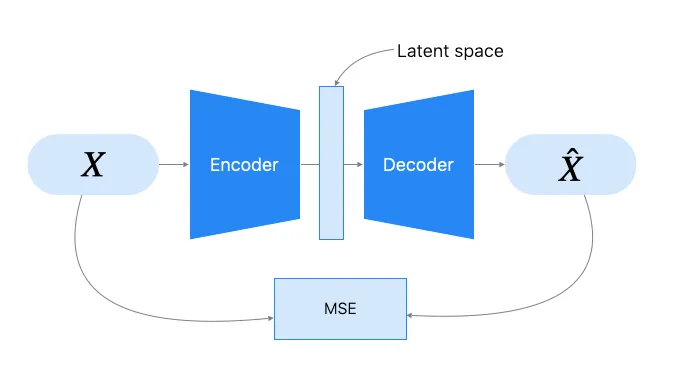

In [9]:
dim_code = 256 # размер латентного вектора

Реализуем autoencoder

In [11]:
from copy import deepcopy
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            # Input: [B, 3, 64, 64]
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # -> [B, 32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # -> [B, 64, 16, 16]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # -> [B, 128, 8, 8]
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # -> [B, 256, 4, 4]
            nn.ReLU(),
            nn.Flatten(),  # -> [B, 256*4*4]
            nn.Linear(256*4*4, 256)  # -> [B, 256]
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(256, 256*4*4),  # -> [B, 256*4*4]
            nn.ReLU(),
            nn.Unflatten(1, (256, 4, 4)),  # -> [B, 256, 4, 4]
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # -> [B, 128, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # -> [B, 64, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # -> [B, 32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # -> [B, 3, 64, 64]
            nn.Sigmoid()  # Ensure output is between [0, 1]
        )

    def forward(self, x):
        # Input shape: [B, 64, 64, 3] -> needs to be [B, 3, 64, 64]
        x = x.permute(0, 3, 1, 2)

        latent_code = self.encoder(x)  # latent representation
        reconstruction = self.decoder(latent_code)  # reconstruction
        reconstruction = reconstruction.permute(0, 2, 3, 1)  # reconstruction in original format [B, 64, 64, 3]

        return reconstruction, latent_code

In [12]:
autoencoder = Autoencoder()  

total_params = sum(p.numel() for p in autoencoder.parameters())
print(f"Total number of parameters: {total_params:,}")

test_batch = X_train_tensor[:2]  # take 2 images
with torch.no_grad():
    recon, latent = autoencoder(test_batch)
    print("\nInput shape:", test_batch.shape)
    print("Latent shape:", latent.shape)
    print("Reconstruction shape:", recon.shape)

Total number of parameters: 3,481,539

Input shape: torch.Size([2, 64, 64, 3])
Latent shape: torch.Size([2, 256])
Reconstruction shape: torch.Size([2, 64, 64, 3])


In [13]:
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

## 1.3 Обучение

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэнкодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

\+ выводить графики train и val лоссов в процессе тренировки =)

In [14]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs=20):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model = None

    vis_batch = next(iter(val_loader))[:8]  # 8 images for visualization

    plt.ion()  # turn on interactive mode
    fig = plt.figure(figsize=(15, 8))

    for epoch in range(n_epochs):
        # Training
        model.train()
        epoch_train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            reconstruction, _ = model(batch)
            loss = criterion(reconstruction, batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                reconstruction, _ = model(batch)
                loss = criterion(reconstruction, batch)
                epoch_val_loss += loss.item()

        epoch_val_loss /= len(val_loader)
        val_losses.append(epoch_val_loss)

        # Save best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model = deepcopy(model.state_dict())

        # Visualize progress
        clear_output(wait=True)
        fig.clear()

        # Plot 1: Training and Validation Losses
        plt.subplot(2, 1, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title(f'Epoch {epoch+1}/{n_epochs}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Plot 2: Original vs Reconstructed Images
        plt.subplot(2, 1, 2)
        with torch.no_grad():
            reconstructions, _ = model(vis_batch)

        orig_images = vis_batch.numpy() # convert tensors to numpy for visualization
        recon_images = reconstructions.numpy()

        for i in range(4):  # show 4 pairs of images
            # Original
            plt.subplot(4, 4, i*2 + 1)
            plt.imshow(orig_images[i])
            plt.axis('off')
            if i == 0:
                plt.title('Original')

            # Reconstruction
            plt.subplot(4, 4, i*2 + 2)
            plt.imshow(recon_images[i])
            plt.axis('off')
            if i == 0:
                plt.title('Reconstructed')

        plt.tight_layout()
        plt.pause(0.1)  # pause to update display

        # print current losses
        print(f'Epoch {epoch+1}/{n_epochs}:')
        print(f'Training Loss: {epoch_train_loss:.4f}')
        print(f'Validation Loss: {epoch_val_loss:.4f}')

    plt.ioff()  # turn off interactive mode

    model.load_state_dict(best_model)  # load best model
    return model, train_losses, val_losses

In [15]:
from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(X_train_tensor, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(X_val_tensor, batch_size=batch_size, shuffle=False)

print("Number of batches in train loader:", len(train_loader))
print("Number of batches in val loader:", len(val_loader))

Number of batches in train loader: 658
Number of batches in val loader: 165


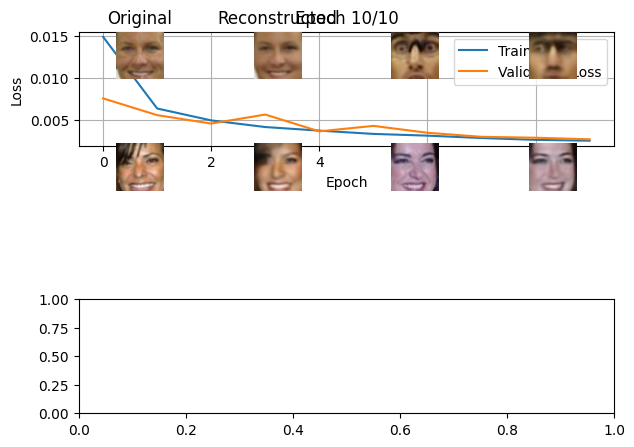

Epoch 10/10:
Training Loss: 0.0026
Validation Loss: 0.0027


In [16]:
# use the training function:
autoencoder, train_losses, val_losses = train_model(
    model=autoencoder,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=10
)

Я специально не учила долго, т.к., попробовав днём ранее обучение на 25-ти эпохах, обнаружила, что примерно после 10-й эпохи начинается ощутимое переобучение - графики лосса для трейна и валидации всё сильнеее расходятся. Поэтому оставила 10 эпох)

Вполне стандартная, насколько я поняла, для автоэнкодеров история - более размытые изображения, нежели оригинальные

## 1.4. Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. 

In [23]:
# Let's see how real latent vectors are distributed
def analyze_latent_distribution(model, val_tensor, n_samples=1000):
    model.eval()
    with torch.no_grad():
        _, latent = model(val_tensor[:n_samples])

    latent_np = latent.numpy()

    # Mean and std of real latent vectors
    mean = np.mean(latent_np, axis=0)
    std = np.std(latent_np, axis=0)

    # Plot histogram of a few dimensions
    plt.figure(figsize=(15, 4))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.hist(latent_np[:, i], bins=30)
        plt.title(f'Dimension {i}')
    plt.tight_layout()
    plt.show()

    return mean, std

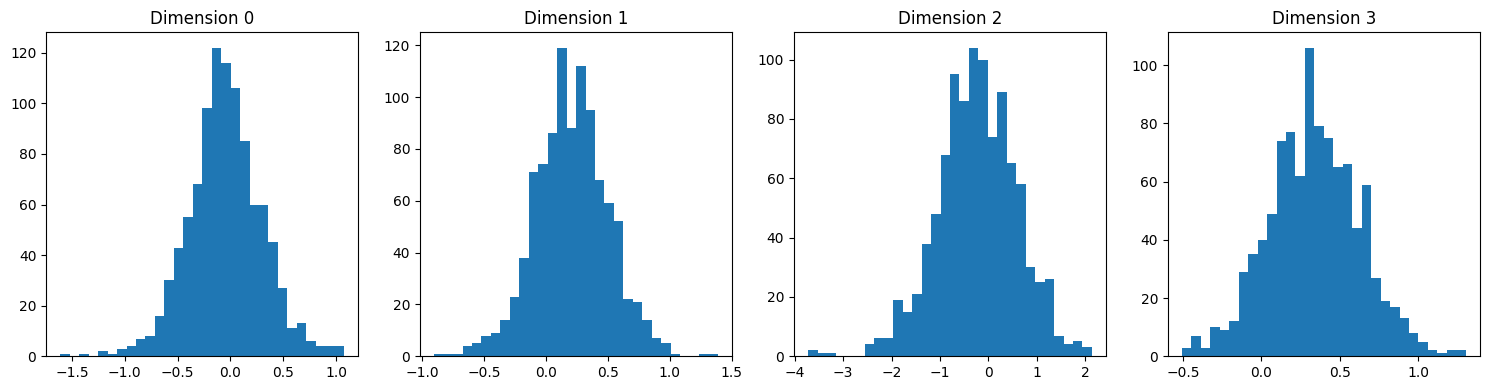

In [24]:
# Get statistics of real latent vectors
mean, std = analyze_latent_distribution(autoencoder, X_val_tensor)

Видим, что не по всем измерениям у нас распределение с центром в 0 и дисперсией 1, как это было бы в случае стандартного нормального распределения

In [25]:
# Generate random vectors with matching distribution
latent_dim = 256  # latent dimension
n_samples = 25
z = np.random.randn(n_samples, latent_dim) * std + mean

In [26]:
# Generate images from random vectors
def generate_from_latent(model, z):
    model.eval()
    with torch.no_grad():
        z_tensor = torch.FloatTensor(z)
        generated = model.decoder(z_tensor)  # generate images using decoder
        if generated.shape[1] == 3:  # if in NCHW format
            generated = generated.permute(0, 2, 3, 1)
    return generated

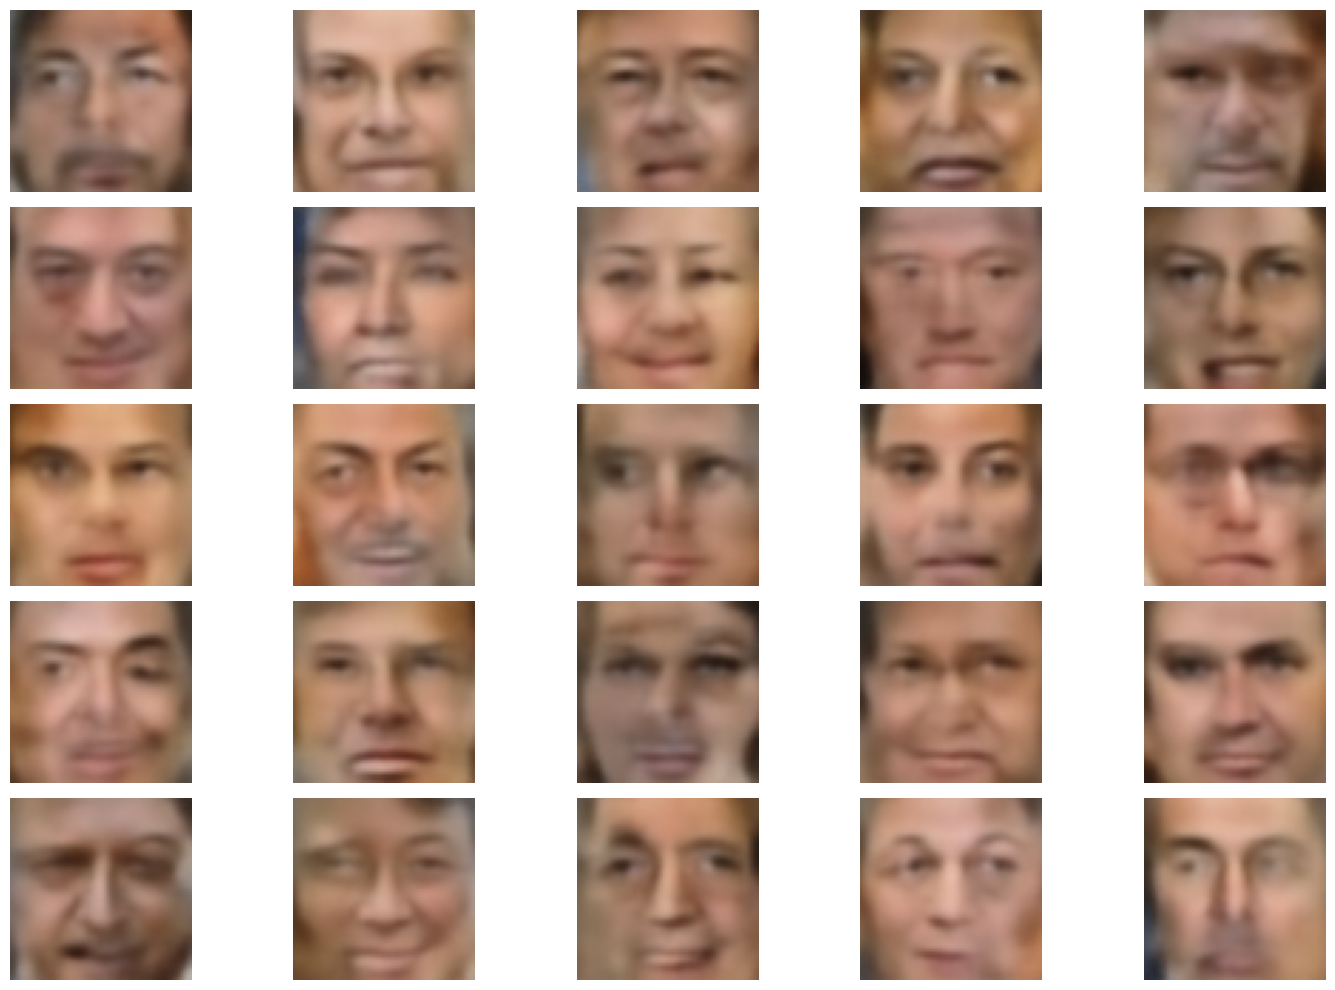

In [28]:
# Generate and display the results
generated_images = generate_from_latent(autoencoder, z) 

plt.figure(figsize=(15, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(generated_images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

Ожидаемое поведение автоэнкодера) 

# Часть 2: Variational Autoencoder

Займемся обучением вариационных автоэнкодеров — улучшенной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [42]:
import torch
from torchvision import datasets, transforms

batch_size = 32
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение

Реализуем VAE

Напишем простую сеть, на одних лишь FC-слоях - для мниста сильно больше не нужно)

In [52]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU()
        )
        # Two separate layers for mu and logsigma
        self.fc_mu = nn.Linear(400, 20)
        self.fc_logsigma = nn.Linear(400, 20)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(20, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()  # for pixel values between 0 and 1
        )

    def encode(self, x):
        x = x.view(-1, 28*28)  # flatten input
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logsigma = self.fc_logsigma(h)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)  # random noise
            return mu + eps * std
        else:
            return mu

    def decode(self, z):
        reconstruction = self.decoder(z)
        reconstruction = reconstruction.view(-1, 1, 28, 28)  # reshape to image format
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)  # sample latent vector using gaussian_sampler
        reconstruction = self.decode(z)  # get reconstruction from decoder

        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [53]:
def KL_divergence(mu, logsigma):
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp()) 
    return loss

def log_likelihood(x, reconstruction):
    x = x.view(-1, 28*28)  # flatten the input
    reconstruction = reconstruction.view(-1, 28*28)  # flatten the reconstruction
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return log_likelihood(x, reconstruction) + KL_divergence(mu, logsigma)  

И обучим модель:

In [54]:
def train_vae(model, train_loader, val_loader, optimizer, epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            mu, logsigma, reconstruction = model(data)
            loss = loss_vae(data, mu, logsigma, reconstruction)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

            if batch_idx % 100 == 0:
                print(f'Epoch {epoch}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item()/len(data):.4f}')

        avg_train_loss = epoch_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for data, _ in val_loader:
                mu, logsigma, reconstruction = model(data)
                loss = loss_vae(data, mu, logsigma, reconstruction)
                epoch_val_loss += loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        print(f'====> Epoch: {epoch}')
        print(f'Average training loss: {avg_train_loss:.4f}')
        print(f'Average validation loss: {avg_val_loss:.4f}')

        # Visualize reconstructions
        if epoch % 1 == 0:
            with torch.no_grad():
                # Get some validation images
                val_data, _ = next(iter(val_loader))
                mu, logsigma, reconstruction = model(val_data[:8])

                plt.figure(figsize=(12, 4))
                for i in range(8):
                    # Original
                    plt.subplot(2, 8, i + 1)
                    plt.imshow(val_data[i][0], cmap='gray')
                    plt.axis('off')
                    if i == 0:
                        plt.title('Original')

                    # Reconstruction
                    plt.subplot(2, 8, i + 9)
                    plt.imshow(reconstruction[i][0].detach(), cmap='gray')
                    plt.axis('off')
                    if i == 0:
                        plt.title('Reconstructed')

                plt.tight_layout()
                plt.show()

    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return train_losses, val_losses

In [55]:
criterion = loss_vae

autoencoder = VAE()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

Epoch 0, Batch 0/1875, Loss: 553.2147
Epoch 0, Batch 100/1875, Loss: 191.4422
Epoch 0, Batch 200/1875, Loss: 171.9128
Epoch 0, Batch 300/1875, Loss: 148.0672
Epoch 0, Batch 400/1875, Loss: 133.5320
Epoch 0, Batch 500/1875, Loss: 131.5979
Epoch 0, Batch 600/1875, Loss: 121.7554
Epoch 0, Batch 700/1875, Loss: 134.8747
Epoch 0, Batch 800/1875, Loss: 132.5719
Epoch 0, Batch 900/1875, Loss: 126.5489
Epoch 0, Batch 1000/1875, Loss: 131.7384
Epoch 0, Batch 1100/1875, Loss: 130.3900
Epoch 0, Batch 1200/1875, Loss: 129.0121
Epoch 0, Batch 1300/1875, Loss: 109.9018
Epoch 0, Batch 1400/1875, Loss: 117.9210
Epoch 0, Batch 1500/1875, Loss: 111.0819
Epoch 0, Batch 1600/1875, Loss: 114.7903
Epoch 0, Batch 1700/1875, Loss: 103.8292
Epoch 0, Batch 1800/1875, Loss: 120.6895
====> Epoch: 0
Average training loss: 136.1311
Average validation loss: 106.2845


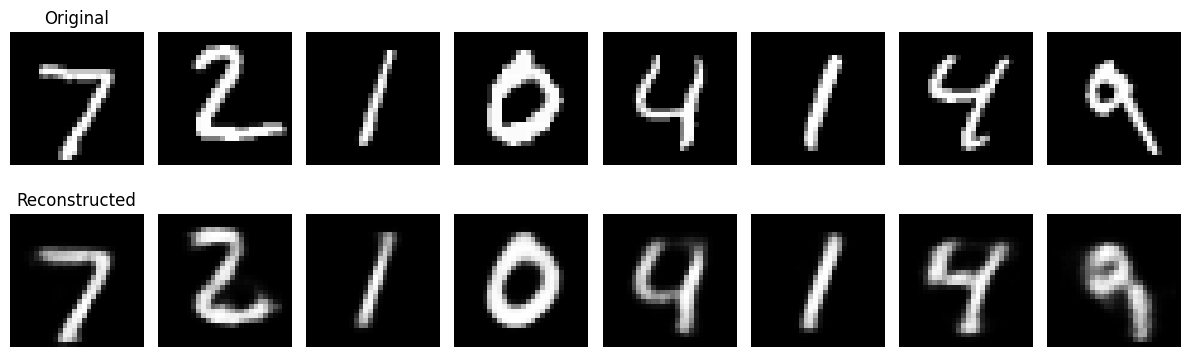

Epoch 1, Batch 0/1875, Loss: 111.5500
Epoch 1, Batch 100/1875, Loss: 112.2214
Epoch 1, Batch 200/1875, Loss: 121.8731
Epoch 1, Batch 300/1875, Loss: 113.9623
Epoch 1, Batch 400/1875, Loss: 112.6799
Epoch 1, Batch 500/1875, Loss: 119.7976
Epoch 1, Batch 600/1875, Loss: 115.6406
Epoch 1, Batch 700/1875, Loss: 113.0366
Epoch 1, Batch 800/1875, Loss: 112.0273
Epoch 1, Batch 900/1875, Loss: 107.8426
Epoch 1, Batch 1000/1875, Loss: 116.4560
Epoch 1, Batch 1100/1875, Loss: 113.6263
Epoch 1, Batch 1200/1875, Loss: 116.7096
Epoch 1, Batch 1300/1875, Loss: 114.1012
Epoch 1, Batch 1400/1875, Loss: 113.0094
Epoch 1, Batch 1500/1875, Loss: 114.3011
Epoch 1, Batch 1600/1875, Loss: 113.0021
Epoch 1, Batch 1700/1875, Loss: 101.3500
Epoch 1, Batch 1800/1875, Loss: 110.4973
====> Epoch: 1
Average training loss: 112.9047
Average validation loss: 101.3836


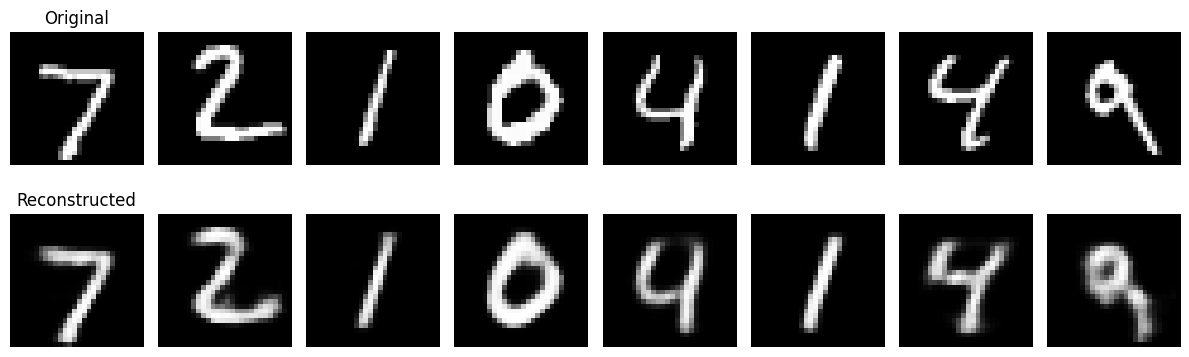

Epoch 2, Batch 0/1875, Loss: 103.7751
Epoch 2, Batch 100/1875, Loss: 115.3489
Epoch 2, Batch 200/1875, Loss: 106.5172
Epoch 2, Batch 300/1875, Loss: 100.4678
Epoch 2, Batch 400/1875, Loss: 108.1265
Epoch 2, Batch 500/1875, Loss: 107.8671
Epoch 2, Batch 600/1875, Loss: 110.9741
Epoch 2, Batch 700/1875, Loss: 115.2542
Epoch 2, Batch 800/1875, Loss: 117.3508
Epoch 2, Batch 900/1875, Loss: 110.4216
Epoch 2, Batch 1000/1875, Loss: 104.8935
Epoch 2, Batch 1100/1875, Loss: 110.2553
Epoch 2, Batch 1200/1875, Loss: 111.4228
Epoch 2, Batch 1300/1875, Loss: 107.2522
Epoch 2, Batch 1400/1875, Loss: 109.1956
Epoch 2, Batch 1500/1875, Loss: 106.9111
Epoch 2, Batch 1600/1875, Loss: 113.6646
Epoch 2, Batch 1700/1875, Loss: 105.0827
Epoch 2, Batch 1800/1875, Loss: 112.8895
====> Epoch: 2
Average training loss: 109.9390
Average validation loss: 100.1816


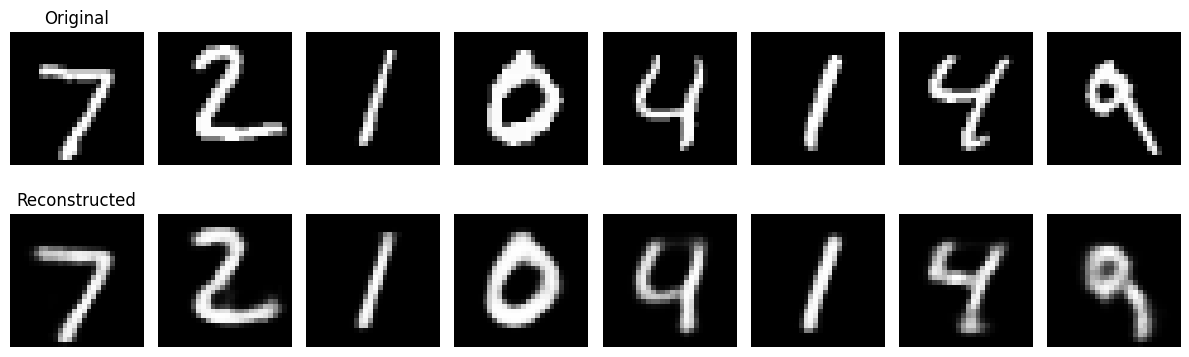

Epoch 3, Batch 0/1875, Loss: 107.0295
Epoch 3, Batch 100/1875, Loss: 100.7284
Epoch 3, Batch 200/1875, Loss: 113.7259
Epoch 3, Batch 300/1875, Loss: 105.7611
Epoch 3, Batch 400/1875, Loss: 100.0018
Epoch 3, Batch 500/1875, Loss: 108.2791
Epoch 3, Batch 600/1875, Loss: 102.6959
Epoch 3, Batch 700/1875, Loss: 105.7600
Epoch 3, Batch 800/1875, Loss: 101.8912
Epoch 3, Batch 900/1875, Loss: 110.2072
Epoch 3, Batch 1000/1875, Loss: 112.5605
Epoch 3, Batch 1100/1875, Loss: 104.2971
Epoch 3, Batch 1200/1875, Loss: 109.3593
Epoch 3, Batch 1300/1875, Loss: 108.8428
Epoch 3, Batch 1400/1875, Loss: 109.8938
Epoch 3, Batch 1500/1875, Loss: 108.6055
Epoch 3, Batch 1600/1875, Loss: 112.1919
Epoch 3, Batch 1700/1875, Loss: 102.0114
Epoch 3, Batch 1800/1875, Loss: 114.5140
====> Epoch: 3
Average training loss: 108.4927
Average validation loss: 98.8641


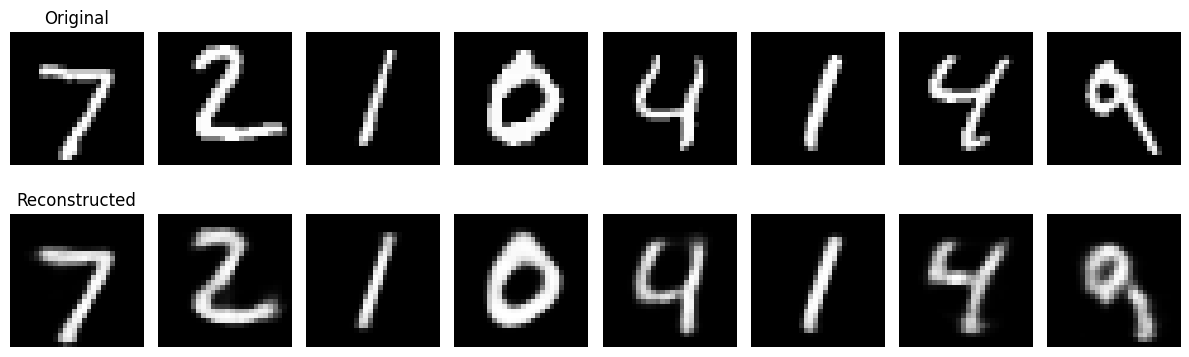

Epoch 4, Batch 0/1875, Loss: 107.3600
Epoch 4, Batch 100/1875, Loss: 108.6236
Epoch 4, Batch 200/1875, Loss: 109.4147
Epoch 4, Batch 300/1875, Loss: 109.7941
Epoch 4, Batch 400/1875, Loss: 112.4815
Epoch 4, Batch 500/1875, Loss: 114.3458
Epoch 4, Batch 600/1875, Loss: 105.8447
Epoch 4, Batch 700/1875, Loss: 111.7026
Epoch 4, Batch 800/1875, Loss: 103.8513
Epoch 4, Batch 900/1875, Loss: 114.4978
Epoch 4, Batch 1000/1875, Loss: 112.5304
Epoch 4, Batch 1100/1875, Loss: 105.1863
Epoch 4, Batch 1200/1875, Loss: 102.2744
Epoch 4, Batch 1300/1875, Loss: 96.7876
Epoch 4, Batch 1400/1875, Loss: 103.7690
Epoch 4, Batch 1500/1875, Loss: 103.8875
Epoch 4, Batch 1600/1875, Loss: 118.5524
Epoch 4, Batch 1700/1875, Loss: 113.3827
Epoch 4, Batch 1800/1875, Loss: 99.9997
====> Epoch: 4
Average training loss: 107.6326
Average validation loss: 98.5284


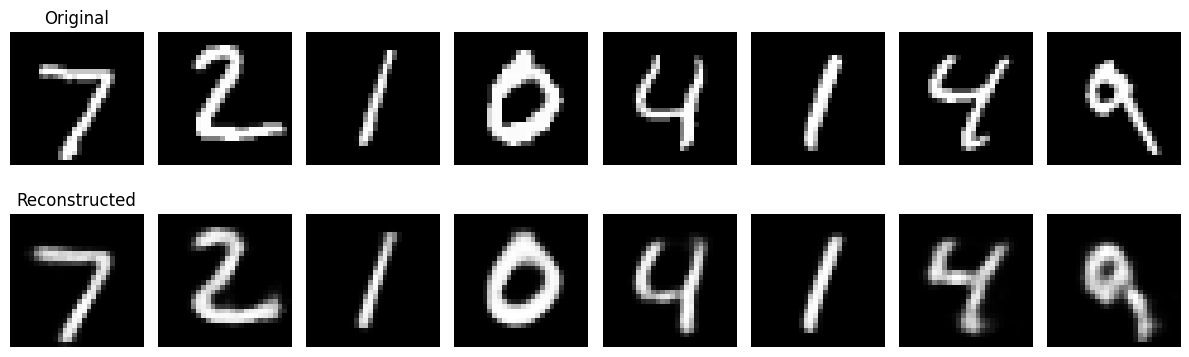

Epoch 5, Batch 0/1875, Loss: 115.8573
Epoch 5, Batch 100/1875, Loss: 110.1010
Epoch 5, Batch 200/1875, Loss: 103.7946
Epoch 5, Batch 300/1875, Loss: 115.0536
Epoch 5, Batch 400/1875, Loss: 114.5123
Epoch 5, Batch 500/1875, Loss: 112.5726
Epoch 5, Batch 600/1875, Loss: 102.1108
Epoch 5, Batch 700/1875, Loss: 104.9578
Epoch 5, Batch 800/1875, Loss: 112.0517
Epoch 5, Batch 900/1875, Loss: 102.0173
Epoch 5, Batch 1000/1875, Loss: 104.6391
Epoch 5, Batch 1100/1875, Loss: 106.3538
Epoch 5, Batch 1200/1875, Loss: 106.2354
Epoch 5, Batch 1300/1875, Loss: 108.6757
Epoch 5, Batch 1400/1875, Loss: 103.1932
Epoch 5, Batch 1500/1875, Loss: 105.7485
Epoch 5, Batch 1600/1875, Loss: 108.6811
Epoch 5, Batch 1700/1875, Loss: 103.0356
Epoch 5, Batch 1800/1875, Loss: 109.4310
====> Epoch: 5
Average training loss: 106.9747
Average validation loss: 97.3374


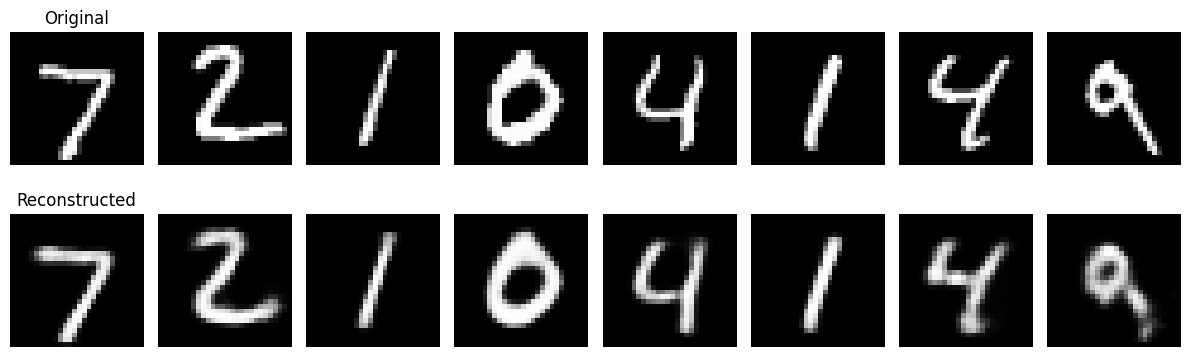

Epoch 6, Batch 0/1875, Loss: 102.9916
Epoch 6, Batch 100/1875, Loss: 106.0462
Epoch 6, Batch 200/1875, Loss: 105.4288
Epoch 6, Batch 300/1875, Loss: 112.0371
Epoch 6, Batch 400/1875, Loss: 104.8215
Epoch 6, Batch 500/1875, Loss: 104.6445
Epoch 6, Batch 600/1875, Loss: 107.7466
Epoch 6, Batch 700/1875, Loss: 110.1509
Epoch 6, Batch 800/1875, Loss: 115.0705
Epoch 6, Batch 900/1875, Loss: 102.3096
Epoch 6, Batch 1000/1875, Loss: 109.3605
Epoch 6, Batch 1100/1875, Loss: 98.2741
Epoch 6, Batch 1200/1875, Loss: 115.1861
Epoch 6, Batch 1300/1875, Loss: 101.9706
Epoch 6, Batch 1400/1875, Loss: 110.5655
Epoch 6, Batch 1500/1875, Loss: 102.3665
Epoch 6, Batch 1600/1875, Loss: 104.7757
Epoch 6, Batch 1700/1875, Loss: 107.7937
Epoch 6, Batch 1800/1875, Loss: 102.5829
====> Epoch: 6
Average training loss: 106.4646
Average validation loss: 97.2562


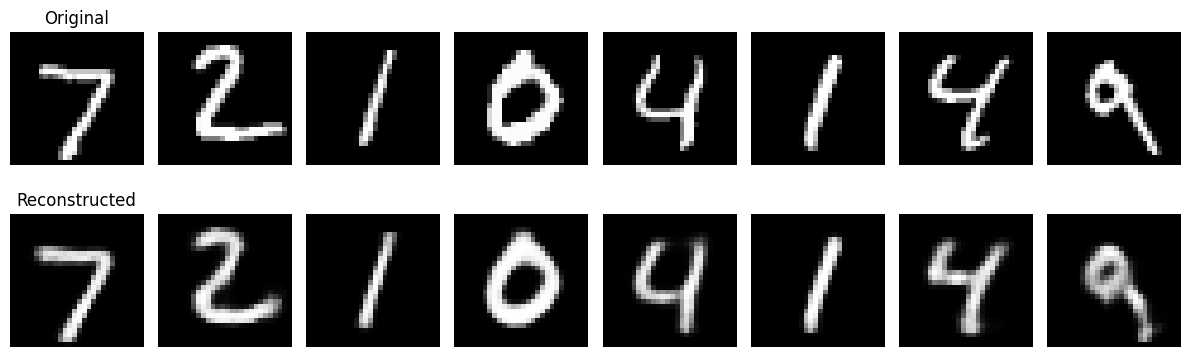

Epoch 7, Batch 0/1875, Loss: 104.9718
Epoch 7, Batch 100/1875, Loss: 105.5045
Epoch 7, Batch 200/1875, Loss: 102.9455
Epoch 7, Batch 300/1875, Loss: 113.2256
Epoch 7, Batch 400/1875, Loss: 108.0592
Epoch 7, Batch 500/1875, Loss: 106.9773
Epoch 7, Batch 600/1875, Loss: 103.6409
Epoch 7, Batch 700/1875, Loss: 99.4751
Epoch 7, Batch 800/1875, Loss: 105.2298
Epoch 7, Batch 900/1875, Loss: 109.9450
Epoch 7, Batch 1000/1875, Loss: 102.0754
Epoch 7, Batch 1100/1875, Loss: 102.2892
Epoch 7, Batch 1200/1875, Loss: 101.7191
Epoch 7, Batch 1300/1875, Loss: 109.8382
Epoch 7, Batch 1400/1875, Loss: 107.3877
Epoch 7, Batch 1500/1875, Loss: 105.6083
Epoch 7, Batch 1600/1875, Loss: 103.7649
Epoch 7, Batch 1700/1875, Loss: 104.5378
Epoch 7, Batch 1800/1875, Loss: 107.1673
====> Epoch: 7
Average training loss: 106.0698
Average validation loss: 96.4530


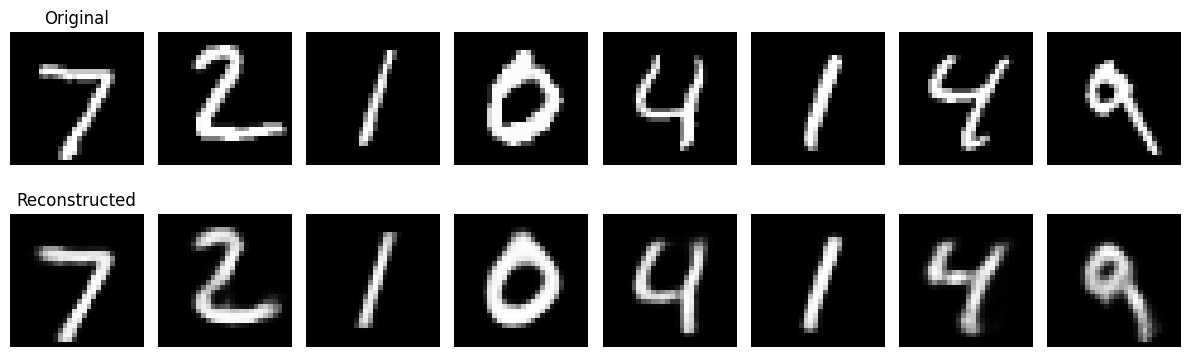

Epoch 8, Batch 0/1875, Loss: 106.2515
Epoch 8, Batch 100/1875, Loss: 107.7606
Epoch 8, Batch 200/1875, Loss: 110.9420
Epoch 8, Batch 300/1875, Loss: 107.0588
Epoch 8, Batch 400/1875, Loss: 104.0113
Epoch 8, Batch 500/1875, Loss: 96.5306
Epoch 8, Batch 600/1875, Loss: 102.4724
Epoch 8, Batch 700/1875, Loss: 105.8702
Epoch 8, Batch 800/1875, Loss: 101.7408
Epoch 8, Batch 900/1875, Loss: 104.3824
Epoch 8, Batch 1000/1875, Loss: 104.4950
Epoch 8, Batch 1100/1875, Loss: 111.6678
Epoch 8, Batch 1200/1875, Loss: 103.2717
Epoch 8, Batch 1300/1875, Loss: 102.9774
Epoch 8, Batch 1400/1875, Loss: 102.6944
Epoch 8, Batch 1500/1875, Loss: 101.1220
Epoch 8, Batch 1600/1875, Loss: 95.8213
Epoch 8, Batch 1700/1875, Loss: 110.5393
Epoch 8, Batch 1800/1875, Loss: 98.9912
====> Epoch: 8
Average training loss: 105.6982
Average validation loss: 96.0504


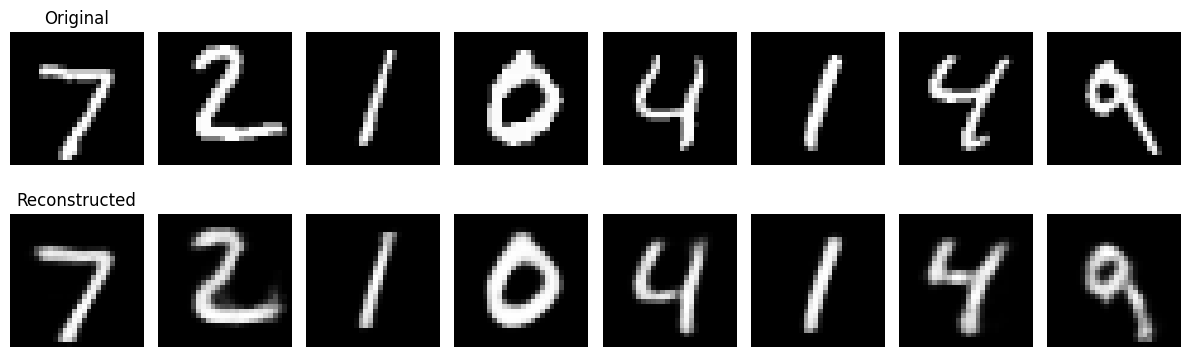

Epoch 9, Batch 0/1875, Loss: 102.8064
Epoch 9, Batch 100/1875, Loss: 103.9380
Epoch 9, Batch 200/1875, Loss: 106.5377
Epoch 9, Batch 300/1875, Loss: 108.5123
Epoch 9, Batch 400/1875, Loss: 104.8362
Epoch 9, Batch 500/1875, Loss: 109.6663
Epoch 9, Batch 600/1875, Loss: 104.0063
Epoch 9, Batch 700/1875, Loss: 100.8787
Epoch 9, Batch 800/1875, Loss: 104.7639
Epoch 9, Batch 900/1875, Loss: 101.2399
Epoch 9, Batch 1000/1875, Loss: 101.5883
Epoch 9, Batch 1100/1875, Loss: 107.1909
Epoch 9, Batch 1200/1875, Loss: 98.0867
Epoch 9, Batch 1300/1875, Loss: 115.2334
Epoch 9, Batch 1400/1875, Loss: 103.7172
Epoch 9, Batch 1500/1875, Loss: 108.7752
Epoch 9, Batch 1600/1875, Loss: 105.9698
Epoch 9, Batch 1700/1875, Loss: 104.7712
Epoch 9, Batch 1800/1875, Loss: 107.6241
====> Epoch: 9
Average training loss: 105.4310
Average validation loss: 96.0087


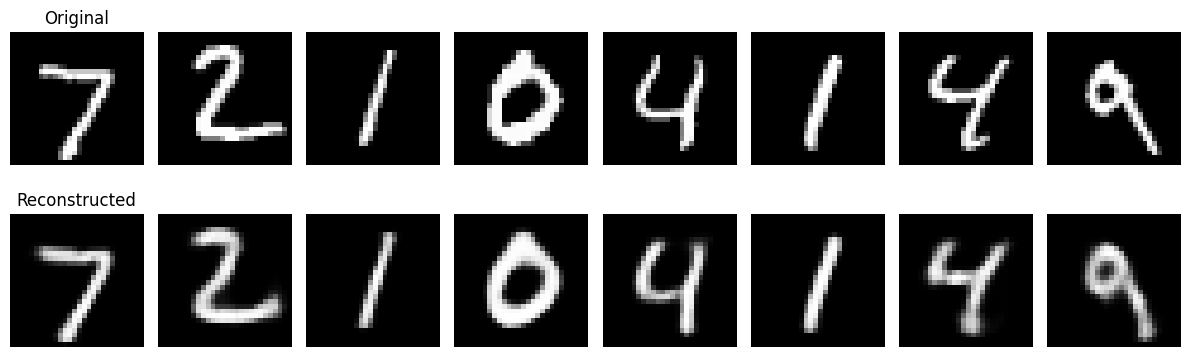

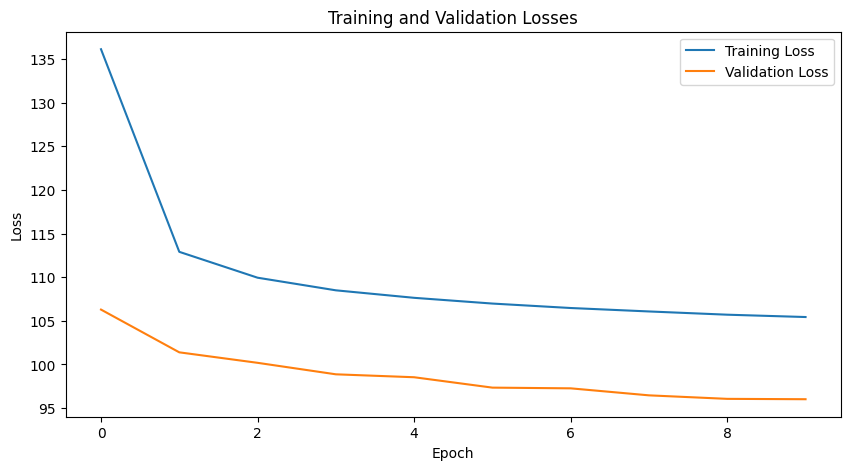

In [57]:
train_losses, val_losses = train_vae(autoencoder, train_loader, test_loader, optimizer, epochs=10)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [60]:
def show_originals_and_reconstructions(model, val_loader, num_images=10):
    model.eval()
    # Get a batch of images
    val_data, _ = next(iter(val_loader))
    val_data = val_data[:num_images]

    with torch.no_grad():
        mu, logsigma, reconstructions = model(val_data)

    plt.figure(figsize=(2*num_images, 4))

    # Original images
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(val_data[i][0], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original')

    # Reconstructed images
    for i in range(num_images):
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructions[i][0], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Reconstructed')

    plt.tight_layout()
    plt.show()

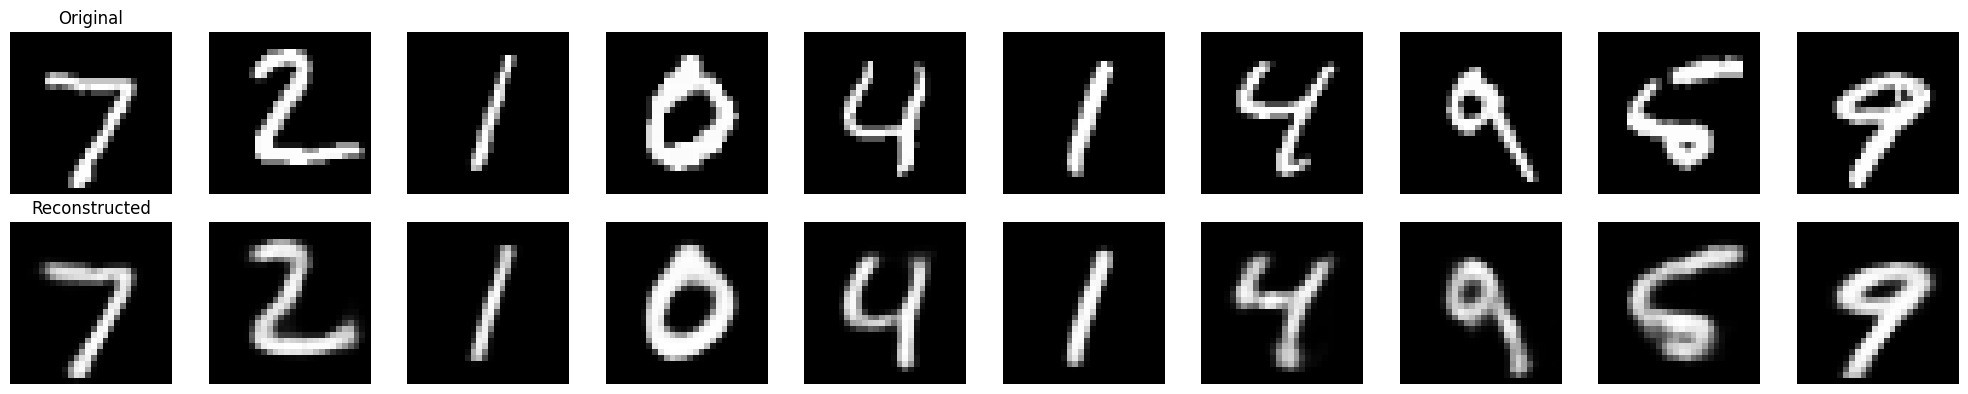

In [61]:
show_originals_and_reconstructions(autoencoder, test_loader)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные вектора из нормального распределения и посмотреть, какие картинки получаются:

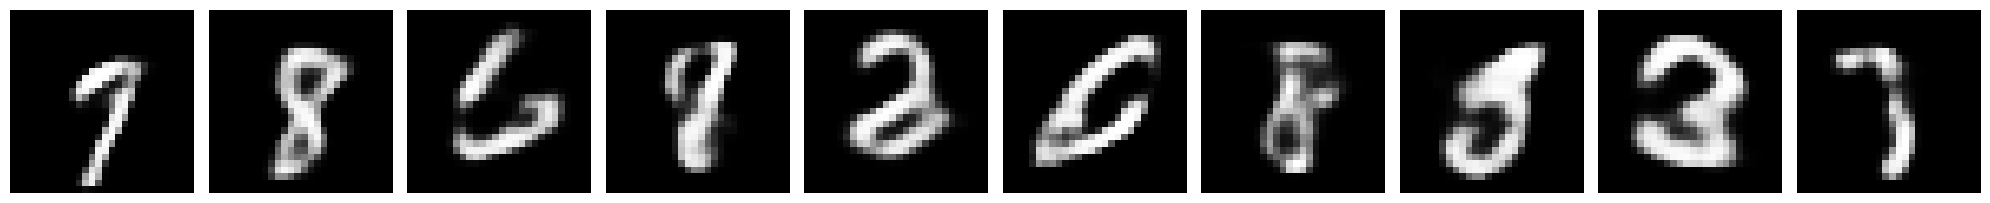

In [62]:
# Create random latent vectors
z = np.array([np.random.normal(0, 1, 20) for i in range(10)])  # 20 = latent dimension
z = torch.FloatTensor(z)

# Generate images
autoencoder.eval()
with torch.no_grad():
    output = autoencoder.decode(z)

# Display generated images
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(output[i][0].numpy(), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

## 2.2. Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощью `TSNE` сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления, покрасить разными цветами точки, соответствующие картинкам разных цифр.

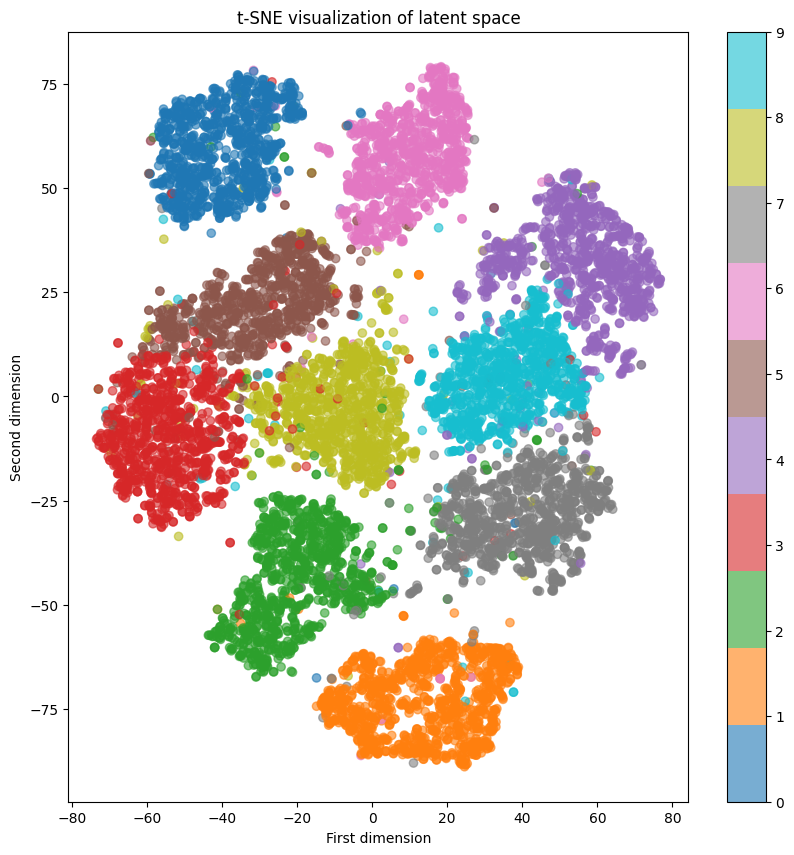

In [66]:
from sklearn.manifold import TSNE
import numpy as np

# Get latent representations of test dataset
def get_latent_representations(model, test_loader):
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for data, target in test_loader:
            mu, logsigma = model.encode(data)
            latent_vectors.append(mu.numpy())
            labels.append(target.numpy())

    return np.vstack(latent_vectors), np.concatenate(labels)

# Get latent vectors and their labels
latent_vecs, labels = get_latent_representations(autoencoder, test_loader)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_vecs)

# Visualize with different colors for different digits
plt.figure(figsize=(10, 10))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1],
                     c=labels, cmap='tab10',  # tab10 is a colormap with 10 distinct colors
                     alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE visualization of latent space')
plt.xlabel('First dimension')
plt.ylabel('Second dimension')
plt.show()

Вид латентного представления сходится с теорией, сходится с тем, что пишут в статьях (via быстрый гуглинг). Всё разумно) переписывать теорию здесь не считаю целесообразным, если коротко - понятно, что так и должно быть

## 2.3. Conditional VAE

Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится :(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — вид автоэнкодера, который предоставляет такую возможность. 

И в этой части мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



Это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [67]:
class CVAE(nn.Module):
    def __init__(self, latent_dim=20, num_classes=10):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder
        # Input: 28x28 image + 10-dim one-hot vector = 784 + 10 dimensions
        self.encoder = nn.Sequential(
            nn.Linear(28*28 + num_classes, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU()
        )

        # Two separate layers for mu and logsigma
        self.fc_mu = nn.Linear(200, latent_dim)
        self.fc_logsigma = nn.Linear(200, latent_dim)

        # Decoder
        # Input: latent_dim + num_classes (one-hot vector)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x, class_num):
        # Convert class_num to one-hot vector
        one_hot = torch.zeros(x.size(0), self.num_classes)
        one_hot[range(x.size(0)), class_num] = 1

        # Flatten image and concatenate with one-hot vector
        x = x.view(-1, 28*28)
        x = torch.cat([x, one_hot], dim=1)

        h = self.encoder(x)  # encode
        mu = self.fc_mu(h)
        logsigma = self.fc_logsigma(h)

        return mu, logsigma, class_num

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z, class_num):
        # Convert class_num to one-hot vector
        one_hot = torch.zeros(z.size(0), self.num_classes)
        one_hot[range(z.size(0)), class_num] = 1

        # Concatenate latent vector with one-hot vector
        z = torch.cat([z, one_hot], dim=1)

        reconstruction = self.decoder(z)  # decode
        reconstruction = reconstruction.view(-1, 1, 28, 28)

        return reconstruction

    def forward(self, x, class_num):
        mu, logsigma, class_num = self.encode(x, class_num)  # encode
        z = self.gaussian_sampler(mu, logsigma)  # sample latent vector
        reconstruction = self.decode(z, class_num)  # decode

        return mu, logsigma, reconstruction

In [69]:
cvae = CVAE(latent_dim=20, num_classes=10)

optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-3)

# Train the model 
def train_cvae(model, train_loader, val_loader, optimizer, epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            mu, logsigma, reconstruction = model(data, labels)
            loss = loss_vae(data, mu, logsigma, reconstruction)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

            if batch_idx % 100 == 0:
                print(f'Epoch {epoch}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item()/len(data):.4f}')

        avg_train_loss = epoch_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for data, labels in val_loader:
                mu, logsigma, reconstruction = model(data, labels)
                loss = loss_vae(data, mu, logsigma, reconstruction)
                epoch_val_loss += loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        print(f'====> Epoch: {epoch}')
        print(f'Average training loss: {avg_train_loss:.4f}')
        print(f'Average validation loss: {avg_val_loss:.4f}')

    return train_losses, val_losses

In [70]:
# train
train_losses, val_losses = train_cvae(cvae, train_loader, test_loader, optimizer, epochs=10)

Epoch 0, Batch 0/1875, Loss: 544.0234
Epoch 0, Batch 100/1875, Loss: 186.7397
Epoch 0, Batch 200/1875, Loss: 181.3969
Epoch 0, Batch 300/1875, Loss: 165.0829
Epoch 0, Batch 400/1875, Loss: 156.9533
Epoch 0, Batch 500/1875, Loss: 141.2074
Epoch 0, Batch 600/1875, Loss: 139.9123
Epoch 0, Batch 700/1875, Loss: 141.7540
Epoch 0, Batch 800/1875, Loss: 132.8307
Epoch 0, Batch 900/1875, Loss: 138.3862
Epoch 0, Batch 1000/1875, Loss: 133.4438
Epoch 0, Batch 1100/1875, Loss: 127.0888
Epoch 0, Batch 1200/1875, Loss: 138.3916
Epoch 0, Batch 1300/1875, Loss: 126.5022
Epoch 0, Batch 1400/1875, Loss: 127.8259
Epoch 0, Batch 1500/1875, Loss: 127.7575
Epoch 0, Batch 1600/1875, Loss: 115.0689
Epoch 0, Batch 1700/1875, Loss: 117.3546
Epoch 0, Batch 1800/1875, Loss: 123.9599
====> Epoch: 0
Average training loss: 141.3712
Average validation loss: 112.1888
Epoch 1, Batch 0/1875, Loss: 112.6049
Epoch 1, Batch 100/1875, Loss: 111.4087
Epoch 1, Batch 200/1875, Loss: 120.3587
Epoch 1, Batch 300/1875, Loss: 116

### Sampling


Тут мы будем сэмплировать из CVAE. Это интереснее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST можно попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

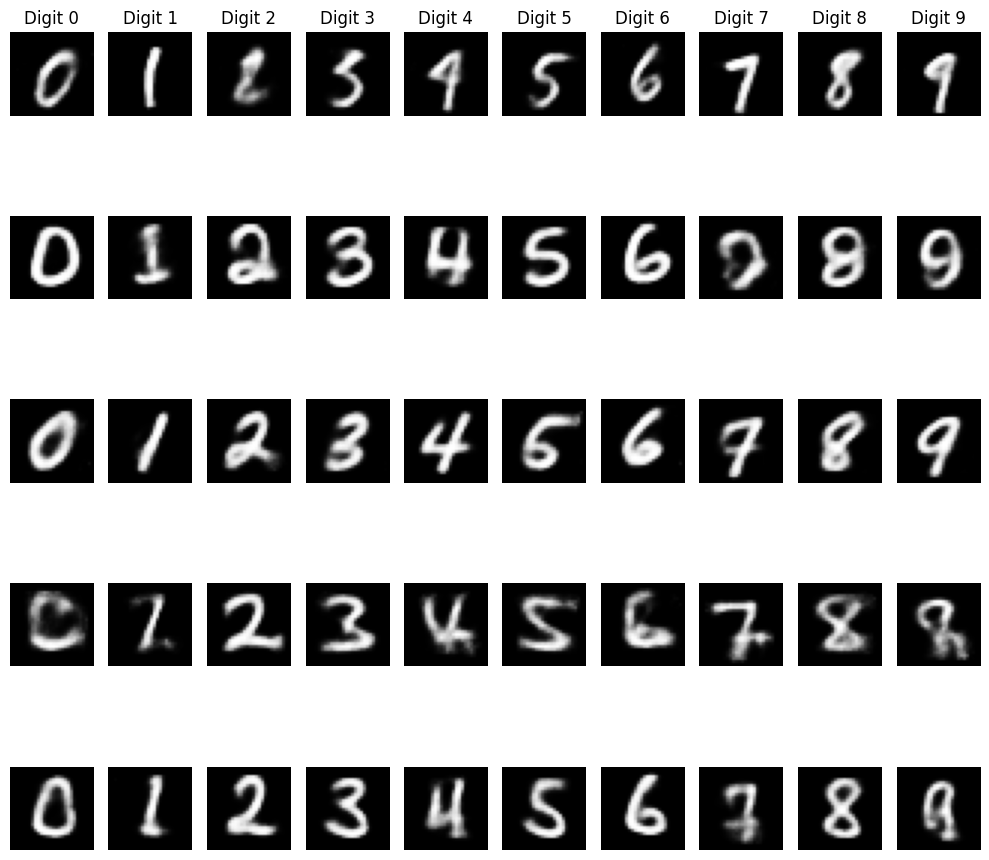

In [71]:
def generate_digits_from_same_latent(model, n_samples=5, latent_dim=20):
    model.eval()
    with torch.no_grad():
        # Generate some random latent vectors
        z = torch.randn(n_samples, latent_dim)

        plt.figure(figsize=(10, 10))

        # For each latent vector, generate all digits (0-9)
        for i in range(n_samples):
            z_i = z[i:i+1]  # Take one latent vector

            # Generate each digit (0-9) from the same latent vector
            for digit in range(10):
                plt.subplot(n_samples, 10, i*10 + digit + 1)

                # Generate image for specific digit
                reconstruction = model.decode(z_i, torch.tensor([digit]))

                plt.imshow(reconstruction[0, 0].numpy(), cmap='gray')
                if i == 0:
                    plt.title(f'Digit {digit}')
                plt.axis('off')

        plt.tight_layout()
        plt.show()

# Generate samples
generate_digits_from_same_latent(cvae)

### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

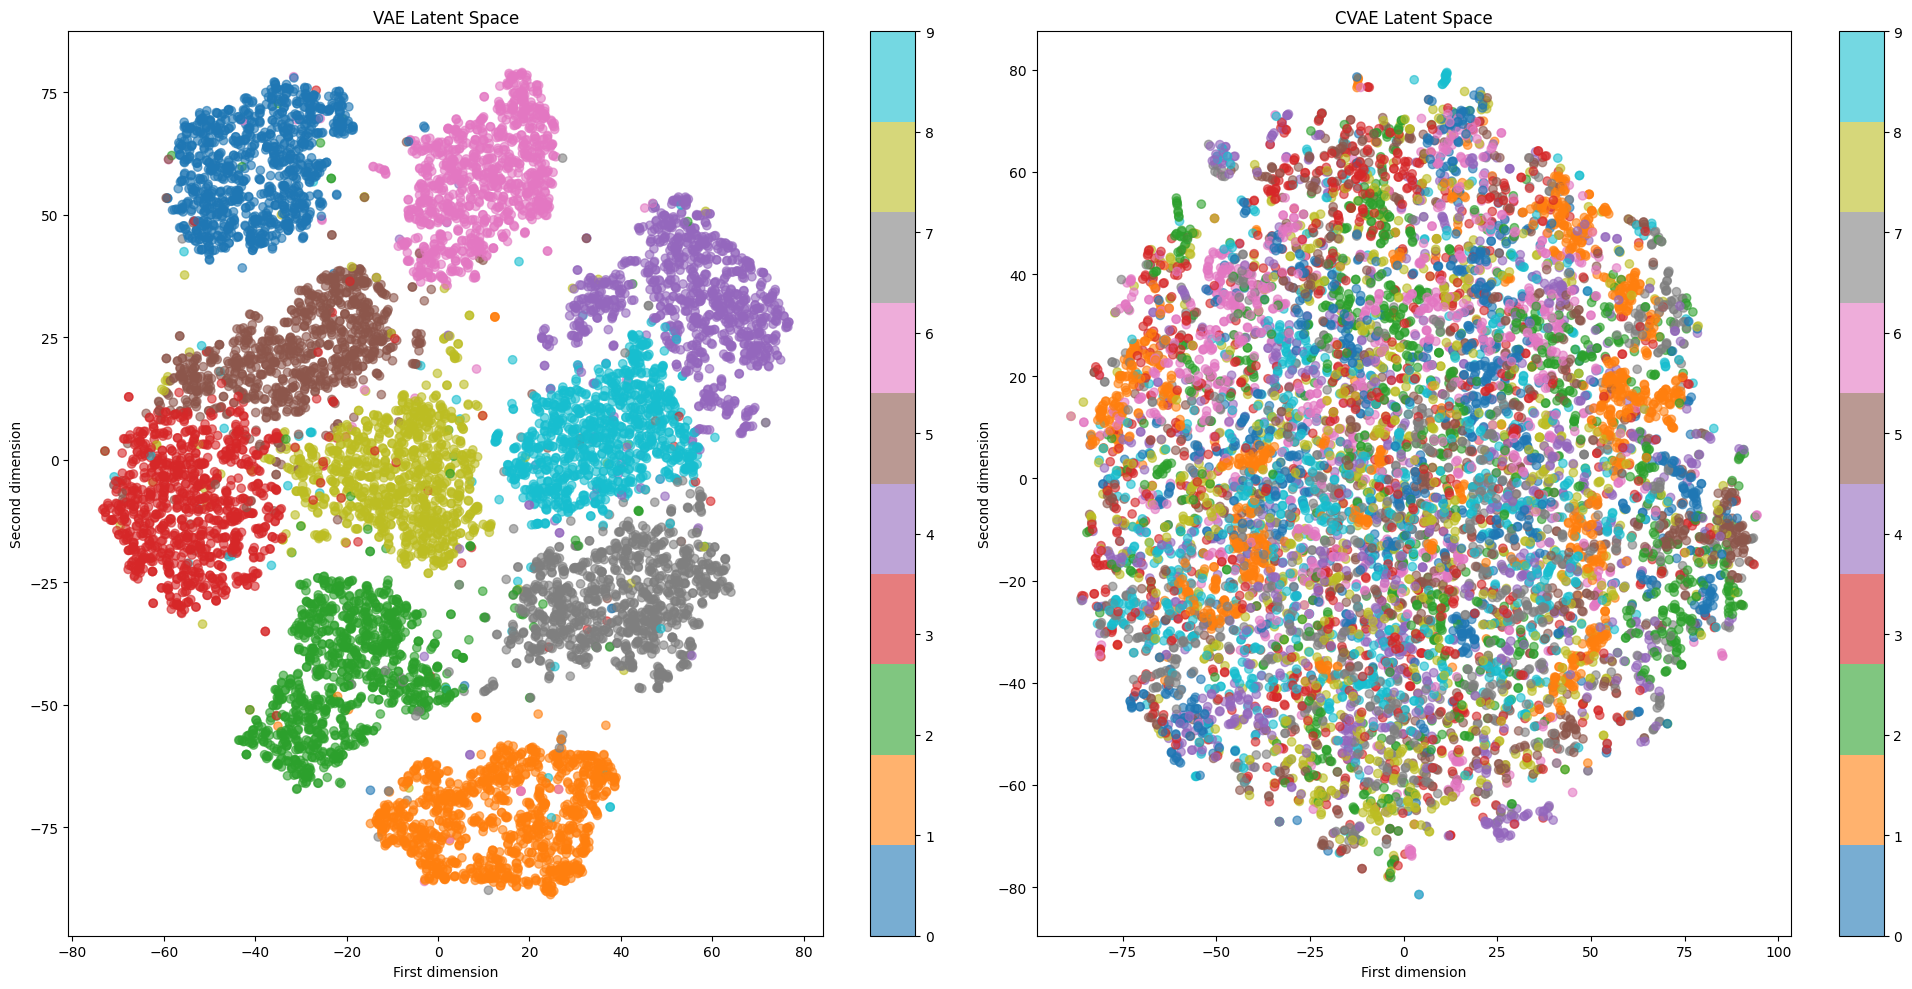

In [72]:
from sklearn.manifold import TSNE

# Get latent representations of test dataset for CVAE
def get_cvae_latent_representations(model, test_loader):
   model.eval()
   latent_vectors = []
   labels = []

   with torch.no_grad():
       for data, target in test_loader:
           mu, logsigma, _ = model.encode(data, target)
           latent_vectors.append(mu.numpy())
           labels.append(target.numpy())

   return np.vstack(latent_vectors), np.concatenate(labels)

# Get latent vectors and their labels for both VAE and CVAE
latent_vecs_vae, labels_vae = get_latent_representations(autoencoder, test_loader)
latent_vecs_cvae, labels_cvae = get_cvae_latent_representations(cvae, test_loader)

# Apply t-SNE to both
tsne = TSNE(n_components=2, random_state=42)
latent_2d_vae = tsne.fit_transform(latent_vecs_vae)
latent_2d_cvae = tsne.fit_transform(latent_vecs_cvae)

# Visualize both side by side
plt.figure(figsize=(20, 10))

# VAE plot
plt.subplot(1, 2, 1)
scatter_vae = plt.scatter(latent_2d_vae[:, 0], latent_2d_vae[:, 1],
                        c=labels_vae, cmap='tab10', alpha=0.6)
plt.colorbar(scatter_vae)
plt.title('VAE Latent Space')
plt.xlabel('First dimension')
plt.ylabel('Second dimension')

# CVAE plot
plt.subplot(1, 2, 2)
scatter_cvae = plt.scatter(latent_2d_cvae[:, 0], latent_2d_cvae[:, 1],
                         c=labels_cvae, cmap='tab10', alpha=0.6)
plt.colorbar(scatter_cvae)
plt.title('CVAE Latent Space')
plt.xlabel('First dimension')
plt.ylabel('Second dimension')

plt.tight_layout()
plt.show()

Картинка для CVAE отличается от картинки для VAE, причём именно так, как и хотелось: для CVAE латентное пространство непрерывно по классам